<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/3_Data_Exploration_and_Time_Series_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this code file, we generate the time series data using the map-matched trajectory dataset.**

In [1]:
# Import Dataframe libraries
import numpy as np
import polars as pl
import pandas as pd

# Import libraries to draw graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Library to cast datetime data
from datetime import timedelta

# Import random module
import random

# Access google drive files
from google.colab import drive

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Access google drive location
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read dataframe with the data
all_data = pl.read_csv('/content/drive/MyDrive/Paper/interpolated_data.csv',try_parse_dates=True)

In [4]:
# Remove duplicate rows
all_data = all_data.unique(keep='first')

In [5]:
# Sort values in dataframe
all_data = all_data.sort(['taxi_id','traj_id','expected_start_time','expected_end_time'])

**There are several columns inside the dataset. Each column stores a specific information.**

**taxi_id** and **traj_id** columns uniquely define together a trajectory of a
taxi.

**osm_way_id** column contains the edges that a specific trajecotry crossed with the correct order.

**edge_length** column contains information about the length (in Km) of the specific edge.

**edge_speed** column contains information about the maximum speed limit inside this specific edge.

**road_class** column contains information about the type of this edge.

**expected_start_time** and **expected_end_time** share information about what time a taxi inserted and exited a specific edge.

In [6]:
# Print first 5 rows of the dataset
all_data.head(5)

taxi_id,traj_id,osm_way_id,edge_length,edge_speed,road_class,expected_start_time,expected_end_time
i64,i64,i64,f64,i64,str,datetime[μs],datetime[μs]
0,0,48582250,0.266,89,"""motorway""",2008-05-17 10:00:29,2008-05-17 10:00:39.579545
0,0,513702094,0.063,89,"""motorway""",2008-05-17 10:00:39.579545,2008-05-17 10:00:42.085227
0,0,513702093,0.12,89,"""motorway""",2008-05-17 10:00:42.085227,2008-05-17 10:00:46.857954
0,0,23925280,0.077,89,"""motorway""",2008-05-17 10:00:46.857954,2008-05-17 10:00:49.920454
0,0,27652284,0.224,89,"""motorway""",2008-05-17 10:00:49.920454,2008-05-17 10:00:58.829545


In [7]:
# Convert polars dataframe into a pandas dataframe
all_data = all_data.to_pandas()

In [8]:
# Delete trajectories, which contain only one edge (OSM Way ID) record, and thus they are useless for our research
uniques = all_data.loc[:, ['taxi_id', 'traj_id']].drop_duplicates(keep=False).index
all_data.drop(uniques,axis=0,inplace=True)
all_data.reset_index(drop=True,inplace=True)
all_data = all_data.reset_index(drop=True)

In [9]:
# Print the shape of the dataset after deleting trajectories with only one record
print(f'The shape of the dataset after deletion is: {all_data.shape}')

The shape of the dataset after deletion is: (67143825, 8)


In [10]:
# Check if there are missing values in the dataset
all_data.isna().sum()

taxi_id                0
traj_id                0
osm_way_id             0
edge_length            0
edge_speed             0
road_class             0
expected_start_time    0
expected_end_time      0
dtype: int64

There are no missing values in the dataset.

In [11]:
# How many trajectories are present in the dataset?
number_of_trajectories = all_data.loc[:, ['taxi_id', 'traj_id']].drop_duplicates().shape[0]
print(f'There are {number_of_trajectories} trajectories present in the dataset.')

There are 521135 trajectories present in the dataset.


In [12]:
# Find max and min timestamp that is present in the dataset
min_timestamp = all_data['expected_start_time'].min()
print("Min timestamp value that is present in the dataset is: ",min_timestamp)

max_timestamp = all_data['expected_end_time'].max()
print("Max timestamp value that is present in the dataset is: ",max_timestamp)

# Calculate total seconds between max and min value
total_sec = (max_timestamp-min_timestamp).total_seconds()
print(f"\nTotal duration of the recordings in this dataset is {total_sec/3600} hours")

Min timestamp value that is present in the dataset is:  2008-05-17 10:00:04
Max timestamp value that is present in the dataset is:  2008-06-10 09:22:05.999995

Total duration of the recordings in this dataset is 575.3672222208334 hours


In [13]:
# This list contains the time intervals that will be used for the time series data
# Each time interval has a duration of 30 minutes.
time_info = []

# Initialize a counter
i = 0

# Iterate until the maximum timestamp is reached
while(True):

    # If it's the first iteration, append the minimum timestamp
    if i == 0:
        time_info.append(min_timestamp)
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        time_info.append(time_info[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to the maximum timestamp
    if (time_info[i] >= max_timestamp):
        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Create pairs of consecutive values of the list time_info
time_intervals = list(zip(*[time_info[i:] for i in range(2)]))

**Generate random unique paths of random lengths**

In [18]:
# Empty dataframe, in which all the unique paths will be saved
paths = pd.DataFrame(columns=['taxi_id','traj_id','path','length'])

# Define the length options
length_options = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# This list is used, in order to be sure that paths created are unique
check = []

# Legal indexes in which algorithm can search for paths
indexes = np.arange(all_data.shape[0]-max(length_options)+1)

i = 0

# Number of paths to be created
n = 100

while (paths.shape[0] < n):

    # This list will save the path created
    p = []

    # Select randomly an index
    selected_index = random.choice(indexes)

    # The length of the new path to be created
    selected_length = random.choice(length_options)

    # check if path is within the same trajectory
    if ((all_data.at[selected_index,'taxi_id'] == all_data.at[selected_index+(selected_length-1),'taxi_id']) &
        (all_data.at[selected_index,'traj_id'] == all_data.at[selected_index+(selected_length-1),'traj_id'])):

        # Iterate to the data and extract the consequtive
        # [selected_index...index+selected_length] osm_way_ids
        for y in range(selected_length):
            p.append(int(all_data.at[selected_index+y,'osm_way_id']))

        # If path is unique, then add it to paths dataframe
        if p not in check:
            check.append(p)

            paths.at[i,'taxi_id'] = all_data.at[selected_index,'taxi_id']
            paths.at[i,'traj_id'] = all_data.at[selected_index,'traj_id']

            # Add the new path to the dataframe
            paths.at[i,'path'] = p
            paths.at[i,'length'] = selected_length
            i += 1
        else:
            continue

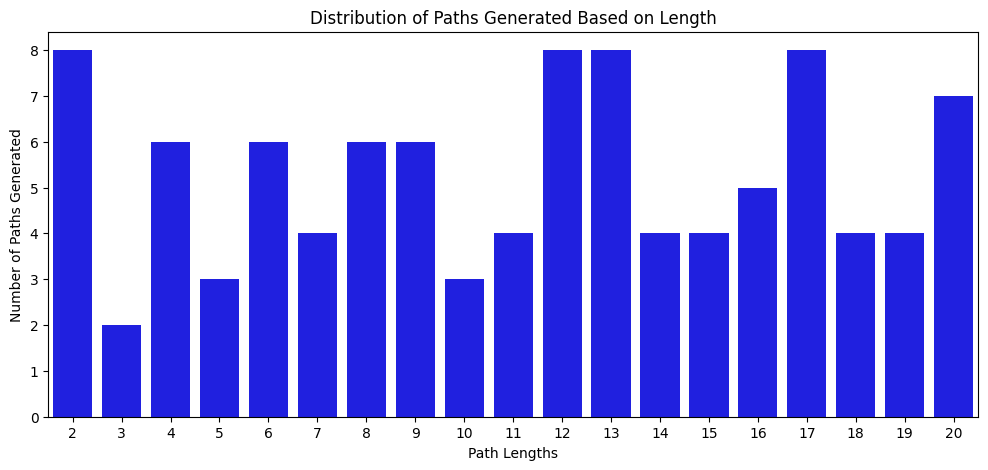

In [19]:
# Count the number of paths grouped by length attribute
plt.figure(figsize=(12,5))
sns.countplot(paths,x='length', color='blue')
plt.xlabel('Path Lengths')
plt.ylabel('Number of Paths Generated')
plt.title('Distribution of Paths Generated Based on Length')
plt.show()

**Create the SPQ algorithm**

In [20]:
def SPQ(path, time_enter, time_leave):
    """
    Find trajectories in the data that follow a specific path within a given time interval.

    Parameters:
    - path (list): List of edges representing the path.
    - time_enter (datetime): Start time of the time interval.
    - time_leave (datetime): End time of the time interval.

    Returns:
    int: Number of unique trajectories that follow the path without performing detours at the given time interval.
    """

    # Length of the path given to the function
    path_length = len(path)

    # This list will save temporarily the trajectories that match the SPQ condition
    trajectories = []

    # Find all the indexes where the first edge in the path is located
    needed_indexes = examined_data[examined_data['osm_way_id'] == path[0]].index

    # Iterate through all indexes (note the Taxi_ID and Traj_ID numbers)
    for index in needed_indexes:
        traj_id = examined_data.at[index, 'traj_id']
        taxi_id = examined_data.at[index, 'taxi_id']
        inter = 1

        # Decide if the row in the next index matches the criteria
        for i in range(1, path_length):
            try:
                if not ((examined_data['osm_way_id'].iloc[index + i] == path[i])
                        & (examined_data['traj_id'].iloc[index + i] == traj_id)
                        & (examined_data['taxi_id'].iloc[index + i] == taxi_id)):
                    break

                inter += 1  # If the criteria match, then increase inter counter by one

            except IndexError:
                pass  # Index out of bounds exception (do nothing)

        # If the criteria match as many times as the length of the path, then we found one trajectory
        if path_length == inter:
            trajectories.append((taxi_id, traj_id))  # Add this trajectory to the trajectories list

    # Return the number of unique trajectories that match the criteria
    return len(set(trajectories))

In [21]:
# Create an empty dataframe to store SPQ timeseries
traffic_flow_SPQ = pd.DataFrame(columns=time_intervals)

# Fill the time series dataset
traffic_flow_SPQ.insert(0,'taxi_id',0)
traffic_flow_SPQ.insert(1,'traj_id',0)
traffic_flow_SPQ.insert(2,'path',0)
traffic_flow_SPQ.insert(3,'length',0)

traffic_flow_SPQ['path'] = paths['path']
traffic_flow_SPQ['length'] = paths['length']
traffic_flow_SPQ['taxi_id'] = paths['taxi_id']
traffic_flow_SPQ['traj_id'] = paths['traj_id']

In [22]:
# Fill the DataFrame column by column
for time in time_intervals:
    i = 0

    # Extract data for the current time interval
    examined_data = all_data[(all_data['expected_start_time'] >= time[0]) & (all_data['expected_end_time'] <= time[1])].reset_index(drop=True)

    # Iterate over paths in the 'paths' DataFrame
    for path in paths['path'].to_list():
        # Call the SPQ function and fill the DataFrame
        traffic_flow_SPQ.at[i, time] = SPQ(path, time[0], time[1])
        i += 1  # Move to the next row in the DataFrame

(Timestamp('2008-05-17 10:00:04'), Timestamp('2008-05-17 10:30:04'))
(Timestamp('2008-05-17 10:30:04'), Timestamp('2008-05-17 11:00:04'))
(Timestamp('2008-05-17 11:00:04'), Timestamp('2008-05-17 11:30:04'))
(Timestamp('2008-05-17 11:30:04'), Timestamp('2008-05-17 12:00:04'))
(Timestamp('2008-05-17 12:00:04'), Timestamp('2008-05-17 12:30:04'))
(Timestamp('2008-05-17 12:30:04'), Timestamp('2008-05-17 13:00:04'))
(Timestamp('2008-05-17 13:00:04'), Timestamp('2008-05-17 13:30:04'))
(Timestamp('2008-05-17 13:30:04'), Timestamp('2008-05-17 14:00:04'))
(Timestamp('2008-05-17 14:00:04'), Timestamp('2008-05-17 14:30:04'))
(Timestamp('2008-05-17 14:30:04'), Timestamp('2008-05-17 15:00:04'))
(Timestamp('2008-05-17 15:00:04'), Timestamp('2008-05-17 15:30:04'))
(Timestamp('2008-05-17 15:30:04'), Timestamp('2008-05-17 16:00:04'))
(Timestamp('2008-05-17 16:00:04'), Timestamp('2008-05-17 16:30:04'))
(Timestamp('2008-05-17 16:30:04'), Timestamp('2008-05-17 17:00:04'))
(Timestamp('2008-05-17 17:00:04'),

In [23]:
# Print the dataframe with SPQ traffic flow information
traffic_flow_SPQ

,taxi_id,traj_id,path,length,"(2008-05-17 10:00:04, 2008-05-17 10:30:04)","(2008-05-17 10:30:04, 2008-05-17 11:00:04)","(2008-05-17 11:00:04, 2008-05-17 11:30:04)","(2008-05-17 11:30:04, 2008-05-17 12:00:04)","(2008-05-17 12:00:04, 2008-05-17 12:30:04)","(2008-05-17 12:30:04, 2008-05-17 13:00:04)",...,"(2008-06-10 04:30:04, 2008-06-10 05:00:04)","(2008-06-10 05:00:04, 2008-06-10 05:30:04)","(2008-06-10 05:30:04, 2008-06-10 06:00:04)","(2008-06-10 06:00:04, 2008-06-10 06:30:04)","(2008-06-10 06:30:04, 2008-06-10 07:00:04)","(2008-06-10 07:00:04, 2008-06-10 07:30:04)","(2008-06-10 07:30:04, 2008-06-10 08:00:04)","(2008-06-10 08:00:04, 2008-06-10 08:30:04)","(2008-06-10 08:30:04, 2008-06-10 09:00:04)","(2008-06-10 09:00:04, 2008-06-10 09:30:04)"
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,11,7,6,3,0,1,...,0,0,0,0,0,0,2,2,0,0
2,313,487,"[8920800, 97637745, 499940843, 499940843]",4,13,6,3,2,3,1,...,0,0,1,0,1,1,3,4,0,1
3,478,468,"[254984059, 8921221, 8921221, 680783337, 39813...",6,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,233,129,"[255168046, 255168046, 617990574, 1111974546, ...",13,1,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,396,931,"[399156531, 399156531, 446598001, 446598001, 4...",6,1,0,0,1,1,2,...,0,1,0,1,2,0,0,0,0,0
96,508,350,"[8916416, 8916416, 996695179, 996695179, 99669...",9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,50,981,"[513704144, 513704144, 671189604, 30593519, 12...",17,2,5,5,10,30,29,...,4,4,6,4,6,3,6,4,1,0
98,170,1371,"[87376672, 87376672, 416878315, 416878315, 911...",13,2,2,5,2,5,0,...,3,1,3,1,2,0,3,1,2,0


In [24]:
# Save dataframe
traffic_flow_SPQ.to_csv('/content/drive/My Drive/Paper/Timeseries/traffic_flow_SPQ.csv',index=False)

**Fill a second time series dataframe without using the SPQ rules**

In [25]:
def no_SPQ(path, time_enter, time_leave):
    '''
    Calculate traffic flow at each path as the number of trajectories that have crossed,
    at least one time, all the edges of the given path at a given time interval.

    Parameters:
      path (list): The path that the trajectories should follow.
      time_enter (datetime): The time, in which the trajectory should enter the first edge of the path given as input.
      time_leave (datetime): The time, in which the trajectory should leave the last edge of the path given as input.

    Returns:
      int: The number of trajectories that passed through this path at the given time interval.
    '''
    # Initialize the count of matching trajectories
    trajectories = 0

    # Find the indexes of entries in 'examined_data' where
    # the first element of the 'path' is present in the 'osm_way_id' column
    needed_indexes = examined_data[examined_data['osm_way_id'] == path[0]].index

    # Convert the 'path' list to a set for efficient subset check
    path_roads = set(path)

    # Loop through the needed indexes to check for matching trajectories
    for index in needed_indexes:

        # Get the 'traj_id' and 'taxi_id' for the current index
        traj_id = examined_data.at[index, 'traj_id']
        taxi_id = examined_data.at[index, 'taxi_id']

        # Find all the 'osm_way_id' values for the current 'traj_id' and 'taxi_id' and store them into a set
        selected_roads = set(examined_data[(examined_data['traj_id'] == traj_id) & (examined_data['taxi_id'] == taxi_id)]['osm_way_id'])

        # Check if the 'path_roads' is a subset of 'selected_roads'
        if path_roads.issubset(selected_roads):
            # Increment the count of matching trajectories
            trajectories += 1

    return trajectories

In [26]:
# Create an empty dataframe to store the time series without the SPQ information
traffic_flow_without_SPQ = pd.DataFrame(columns=time_intervals)

# Fill the time series dataset
traffic_flow_without_SPQ.insert(0,'taxi_id',0)
traffic_flow_without_SPQ.insert(1,'traj_id',0)
traffic_flow_without_SPQ.insert(2,'path',0)
traffic_flow_without_SPQ.insert(3,'length',0)

traffic_flow_without_SPQ['path'] = paths.iloc[0:100]['path']
traffic_flow_without_SPQ['length'] = paths['length']
traffic_flow_without_SPQ['taxi_id'] = paths['taxi_id']
traffic_flow_without_SPQ['traj_id'] = paths['traj_id']

In [27]:
# For each time interval of 30-minutes, do the following:
for time in time_intervals:
    # Initialize a counter for indexing results in timeseries
    i = 0
    # Use only the necessary data within the current time interval
    examined_data = all_data[(all_data['expected_start_time'] >= time[0]) & (all_data['expected_end_time'] <= time[1])].reset_index(drop=True)

    # For each path, do the following:
    for path in paths.iloc[0:100]['path'].to_list():

        # Calculate the number of trajectories and mean crossing time using the no_SPQ function
        # Update the timeseries with the calculated values
        traffic_flow_without_SPQ.at[i, time] = no_SPQ(path, time[0], time[1])

        # Increment the index counter
        i += 1

    # Print the current time interval for progress tracking
    print(time)

(Timestamp('2008-05-17 10:00:04'), Timestamp('2008-05-17 10:30:04'))
(Timestamp('2008-05-17 10:30:04'), Timestamp('2008-05-17 11:00:04'))
(Timestamp('2008-05-17 11:00:04'), Timestamp('2008-05-17 11:30:04'))
(Timestamp('2008-05-17 11:30:04'), Timestamp('2008-05-17 12:00:04'))
(Timestamp('2008-05-17 12:00:04'), Timestamp('2008-05-17 12:30:04'))
(Timestamp('2008-05-17 12:30:04'), Timestamp('2008-05-17 13:00:04'))
(Timestamp('2008-05-17 13:00:04'), Timestamp('2008-05-17 13:30:04'))
(Timestamp('2008-05-17 13:30:04'), Timestamp('2008-05-17 14:00:04'))
(Timestamp('2008-05-17 14:00:04'), Timestamp('2008-05-17 14:30:04'))
(Timestamp('2008-05-17 14:30:04'), Timestamp('2008-05-17 15:00:04'))
(Timestamp('2008-05-17 15:00:04'), Timestamp('2008-05-17 15:30:04'))
(Timestamp('2008-05-17 15:30:04'), Timestamp('2008-05-17 16:00:04'))
(Timestamp('2008-05-17 16:00:04'), Timestamp('2008-05-17 16:30:04'))
(Timestamp('2008-05-17 16:30:04'), Timestamp('2008-05-17 17:00:04'))
(Timestamp('2008-05-17 17:00:04'),

In [28]:
# Print the dataframe without the SPQ traffic flow information
traffic_flow_without_SPQ

,taxi_id,traj_id,path,length,"(2008-05-17 10:00:04, 2008-05-17 10:30:04)","(2008-05-17 10:30:04, 2008-05-17 11:00:04)","(2008-05-17 11:00:04, 2008-05-17 11:30:04)","(2008-05-17 11:30:04, 2008-05-17 12:00:04)","(2008-05-17 12:00:04, 2008-05-17 12:30:04)","(2008-05-17 12:30:04, 2008-05-17 13:00:04)",...,"(2008-06-10 04:30:04, 2008-06-10 05:00:04)","(2008-06-10 05:00:04, 2008-06-10 05:30:04)","(2008-06-10 05:30:04, 2008-06-10 06:00:04)","(2008-06-10 06:00:04, 2008-06-10 06:30:04)","(2008-06-10 06:30:04, 2008-06-10 07:00:04)","(2008-06-10 07:00:04, 2008-06-10 07:30:04)","(2008-06-10 07:30:04, 2008-06-10 08:00:04)","(2008-06-10 08:00:04, 2008-06-10 08:30:04)","(2008-06-10 08:30:04, 2008-06-10 09:00:04)","(2008-06-10 09:00:04, 2008-06-10 09:30:04)"
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,11,0,0,0,...,0,0,11,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,101,39,44,27,0,21,...,0,0,0,0,0,9,17,24,0,0
2,313,487,"[8920800, 97637745, 499940843, 499940843]",4,87,97,56,38,64,13,...,0,0,8,4,10,4,22,34,6,7
3,478,468,"[254984059, 8921221, 8921221, 680783337, 39813...",6,0,0,5,0,5,0,...,0,5,0,0,0,0,0,0,0,0
4,233,129,"[255168046, 255168046, 617990574, 1111974546, ...",13,2,0,4,2,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,396,931,"[399156531, 399156531, 446598001, 446598001, 4...",6,65,22,2,8,11,13,...,11,22,8,22,25,0,22,0,15,0
96,508,350,"[8916416, 8916416, 996695179, 996695179, 99669...",9,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
97,50,981,"[513704144, 513704144, 671189604, 30593519, 12...",17,4,10,10,20,61,60,...,8,8,12,8,12,6,12,8,3,0
98,170,1371,"[87376672, 87376672, 416878315, 416878315, 911...",13,4,4,10,4,10,0,...,6,2,6,2,4,0,6,4,6,0


In [29]:
# Save dataframe to csv
traffic_flow_without_SPQ.to_csv('/content/drive/My Drive/Paper/Timeseries/traffic_flow_without_SPQ.csv',index=False)